## initial test

In [21]:
import time
from functools import partial
from typing import Callable

import jax.numpy as jnp
import typer
from jax import Array, jit, random, vmap
from jax._src.prng import PRNGKeyArray
from jax.scipy import stats

from bpd import DATA_DIR
from bpd.chains import run_sampling_nuts, run_warmup_nuts
from bpd.draw import draw_gaussian
from bpd.prior import ellip_prior_e1e2
from bpd.sample import (
    get_target_images,
    get_true_params_from_galaxy_params,
    sample_target_galaxy_params_simple,
)

import matplotlib.pyplot as plt

In [10]:
def logprior(
    params: dict[str, Array],
    *,
    sigma_e: float,
    sigma_x: float = 0.5,  # pixels
    flux_bds: tuple = (-1.0, 9.0),
    hlr_bds: tuple = (0.01, 5.0),
) -> Array:
    prior = jnp.array(0.0)

    f1, f2 = flux_bds
    prior += stats.uniform.logpdf(params["lf"], f1, f2 - f1)

    h1, h2 = hlr_bds
    prior += stats.uniform.logpdf(params["hlr"], h1, h2 - h1)

    prior += stats.norm.logpdf(params["x"], loc=0.0, scale=sigma_x)
    prior += stats.norm.logpdf(params["y"], loc=0.0, scale=sigma_x)

    e1e2 = jnp.stack((params["e1"], params["e2"]), axis=-1)
    prior += jnp.log(ellip_prior_e1e2(e1e2, sigma=sigma_e))

    return prior

In [11]:
def loglikelihood(
    params: dict[str, Array],
    data: Array,
    *,
    draw_fnc: Callable,
    background: float,
):
    _draw_params = {**params}
    _draw_params["f"] = 10 ** _draw_params.pop("lf")
    model = draw_fnc(**_draw_params)
    likelihood_pp = stats.norm.logpdf(data, loc=model, scale=jnp.sqrt(background))
    return jnp.sum(likelihood_pp)


def _init_fnc(image: Array):
    assert image.ndim == 2
    assert image.shape[0] == image.shape[1]
    flux = image.sum()
    hlr = 0.95  # median size
    e1 = 0.0
    e2 = 0.0
    x = 0.0
    y = 0.0
    return {"lf": jnp.log10(flux), "hlr": hlr, "e1": e1, "e2": e2, "x": x, "y": y}


def logtarget(
    params: dict[str, Array],
    data: Array,
    *,
    logprior_fnc: Callable,
    loglikelihood_fnc: Callable,
):
    return logprior_fnc(params) + loglikelihood_fnc(params, data)


def sample_prior(
    rng_key: PRNGKeyArray,
    *,
    shape_noise: float,
    mean_logflux: float = 2.6,
    sigma_logflux: float = 0.4,
    hlr_bds: tuple[float, float] = (0.7, 1.2),
    g1: float = 0.02,
    g2: float = 0.0,
) -> dict[str, float]:
    k1, k2, k3 = random.split(rng_key, 3)

    lf = random.normal(k1) * sigma_logflux + mean_logflux
    hlr = random.uniform(k2, minval=hlr_bds[0], maxval=hlr_bds[1])
    other_params = sample_target_galaxy_params_simple(
        k3, shape_noise=shape_noise, g1=g1, g2=g2
    )

    return {"lf": lf, "hlr": hlr, **other_params}

In [12]:
rng_key = random.key(42)
k1, k2, k3 = random.split(rng_key, 3)

In [13]:
slen = 63
fft_size = 256
shape_noise = 0.3
sigma_e_int = 0.4
background = 1.0

In [14]:
# setup target density
draw_fnc = partial(draw_gaussian, slen=slen, fft_size=fft_size)
_loglikelihood = partial(loglikelihood, draw_fnc=draw_fnc, background=background)
_logprior = partial(logprior, sigma_e=sigma_e_int)
_logtarget = partial(
    logtarget, logprior_fnc=_logprior, loglikelihood_fnc=_loglikelihood
)

In [17]:
# setup nuts functions
_run_warmup1 = partial(
    run_warmup_nuts,
    logtarget=_logtarget,
    initial_step_size=0.1,
    max_num_doublings=5,
    n_warmup_steps=500,
)
_run_warmup = vmap(jit(_run_warmup1))

_run_sampling1 = partial(
    run_sampling_nuts,
    logtarget=_logtarget,
    n_samples=200,
    max_num_doublings=5,
)
_run_sampling = vmap(jit(_run_sampling1))

In [18]:
n_gals = 10

In [20]:
k1s = random.split(k1, n_gals)
galaxy_params = vmap(partial(sample_prior, shape_noise=shape_noise))(k1s)

In [22]:
# get images
draw_params = {**galaxy_params}
draw_params["f"] = 10 ** draw_params.pop("lf")
target_images = get_target_images(
    nkey, draw_params, background=background, slen=slen
)
assert target_images.shape == (n_gals, slen, slen)

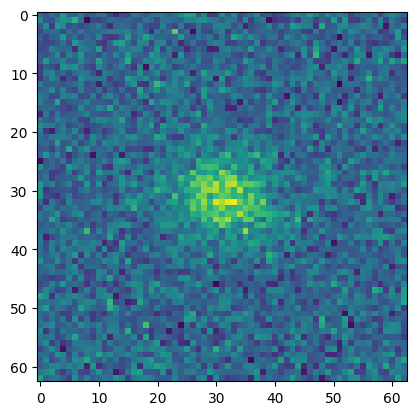

In [30]:
plt.imshow(target_images[9])

In [35]:
# # initialize positions
# init_positions = vmap(_init_fnc)(target_images)
# init_positions, galaxy_params

({'e1': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float64, weak_type=True),
  'e2': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float64, weak_type=True),
  'hlr': Array([0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95],      dtype=float64, weak_type=True),
  'lf': Array([2.38970726, 2.01077205, 2.68182783, 3.09255868, 2.21471423,
         2.7988639 , 3.19258205, 3.02693035, 2.54109748, 2.85379967],      dtype=float64),
  'x': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float64, weak_type=True),
  'y': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float64, weak_type=True)},
 {'e1': Array([-0.13730287,  0.34650732, -0.18141658,  0.04518224,  0.1091972 ,
          0.14563153, -0.3166311 , -0.20418099,  0.01199936,  0.13784756],      dtype=float64),
  'e2': Array([-0.13492882, -0.11909088, -0.1907017 , -0.18514793,  0.06411043,
          0.13044872, -0.04551223, -0.6180162 , -0.22342223,  0.1649657 ],      dtype=float64),
  'g1': Array([0.

In [44]:
init_positions = vmap(get_true_params_from_galaxy_params)(galaxy_params)

In [45]:
init_positions

{'e1': Array([-0.11725889,  0.36426258, -0.16126938,  0.06580685,  0.12899729,
         0.16548775, -0.29847932, -0.17720725,  0.0329889 ,  0.15795316],      dtype=float64),
 'e2': Array([-0.13561767, -0.1174096 , -0.19201348, -0.18473731,  0.06380568,
         0.12963937, -0.0460757 , -0.62274962, -0.22322125,  0.16399244],      dtype=float64),
 'hlr': Array([0.85162797, 1.08727508, 0.7175488 , 1.061069  , 1.01220836,
        1.10519897, 1.10178552, 1.18106628, 1.1012382 , 1.02441114],      dtype=float64),
 'lf': Array([2.44387667, 2.29318242, 2.71613174, 3.11051695, 2.32917254,
        2.7949633 , 3.18331156, 3.02307659, 2.55491694, 2.87832373],      dtype=float64),
 'x': Array([-0.28585416, -0.44258088,  0.24662322,  0.06594777,  0.28199315,
         0.08823019,  0.46014224,  0.18794353,  0.30843203,  0.37212524],      dtype=float64),
 'y': Array([-2.66140416e-01, -3.84976143e-01, -1.33743499e-01, -3.20456893e-01,
        -1.67905214e-04,  2.60592934e-01,  1.41592022e-01,  2.7934455

In [46]:
k2s = random.split(k2, n_gals)
k3s = random.split(k3, n_gals)

In [47]:
init_states, tuned_params, adapt_info = _run_warmup(
    k2s, init_positions, target_images
)

In [48]:
tuned_params.pop("max_num_doublings")  # set above, not jittable
samples, _ = _run_sampling(k3s, init_states, tuned_params, target_images)


In [49]:
samples

{'e1': Array([[-0.25219342, -0.25940391, -0.29680981, ..., -0.2510121 ,
         -0.21409468, -0.31573559],
        [ 0.07938479,  0.0167728 ,  0.03482818, ...,  0.18612997,
          0.13827889,  0.25903559],
        [-0.19734884, -0.12043677, -0.18549889, ..., -0.20486039,
         -0.12539316, -0.21314024],
        ...,
        [-0.21215237, -0.19414747, -0.2180079 , ..., -0.18410329,
         -0.21097291, -0.20085457],
        [-0.06120438,  0.03309582,  0.07334841, ..., -0.07140671,
          0.13122389, -0.08297709],
        [ 0.11603707,  0.14511894,  0.16598748, ...,  0.15151655,
          0.10852876,  0.11779359]], dtype=float64),
 'e2': Array([[-0.1429302 , -0.16454125, -0.17571172, ..., -0.15960772,
         -0.10187335, -0.14977726],
        [-0.22635718, -0.28837774, -0.23334168, ..., -0.16252346,
          0.09876281, -0.22663748],
        [-0.15232007, -0.14952801, -0.11176003, ..., -0.11890495,
         -0.18636206, -0.1536558 ],
        ...,
        [-0.64411352, -0.64

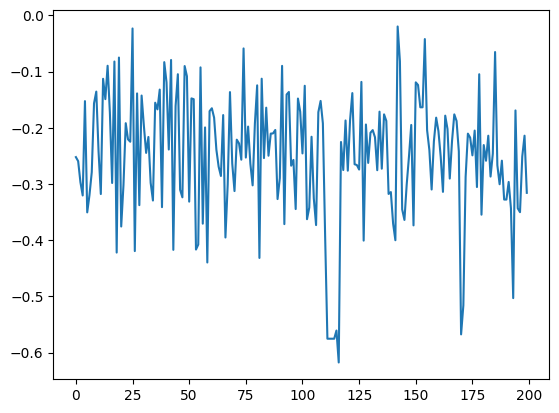

In [51]:
plt.plot(samples['e1'][0, :])

In [ ]:
        # warmup
        t1 = time.time()

        t2 = time.time()
        t_warmup = t2 - t1

        # inference
        t1 = time.time()
        t2 = time.time()
        t_sampling = t2 - t1

        true_params = vmap(get_true_params_from_galaxy_params)(galaxy_params)

        results[n_gals] = {}
        results[n_gals]["t_warmup"] = t_warmup
        results[n_gals]["t_sampling"] = t_sampling
        results[n_gals]["samples"] = samples
        results[n_gals]["truth"] = true_params
        results[n_gals]["adapt_info"] = adapt_info
        results[n_gals]["tuned_params"] = tuned_params

    jnp.save(fpath, results)

## Another test (exp 21)

In [1]:
#!/usr/bin/env python3
"""This experiment is more attuned to what we will use for final results."""

import time
from functools import partial
from typing import Callable

import jax.numpy as jnp
import typer
import jax
from jax import Array, jit, random, vmap
from jax._src.prng import PRNGKeyArray

from bpd import DATA_DIR
from bpd.chains import run_sampling_nuts, run_warmup_nuts
from bpd.draw import draw_gaussian
from bpd.likelihood import gaussian_image_loglikelihood
from bpd.pipelines import logtarget_images
from bpd.prior import interim_gprops_logprior
from bpd.sample import (
    get_target_images,
    get_true_params_from_galaxy_params,
    sample_target_galaxy_params_simple,
)

import matplotlib.pyplot as plt 

def sample_prior(
    rng_key: PRNGKeyArray,
    *,
    shape_noise: float,
    mean_logflux: float = 2.6,
    sigma_logflux: float = 0.4,
    mean_loghlr: float = -0.1,
    sigma_loghlr: float = 0.05,
    g1: float = 0.02,
    g2: float = 0.0,
) -> dict[str, float]:
    k1, k2, k3 = random.split(rng_key, 3)

    lf = random.normal(k1) * sigma_logflux + mean_logflux
    lhlr = random.normal(k2) * sigma_loghlr + mean_loghlr
    other_params = sample_target_galaxy_params_simple(
        k3, shape_noise=shape_noise, g1=g1, g2=g2
    )

    return {"lf": lf, "lhlr": lhlr, **other_params}

def _init_fnc(key: PRNGKeyArray, image: Array, true_params: dict):
    assert image.ndim == 2
    assert image.shape[0] == image.shape[1]

    k1, k2, k3 = random.split(key, 3)
    flux = image.sum()

    tlhlr = true_params["lhlr"]
    lhlr = random.normal(k1) * 0.015 + tlhlr

    te1 = true_params['e1']
    e1 = random.uniform(k2, shape=(), minval=te1 - 0.1, maxval=te1 + 0.1)


    te2 = true_params['e2']
    e2 = random.uniform(k3, shape=(), minval=te2 - 0.1, maxval=te2 + 0.1)

    return {
        "lf": jnp.log10(flux),
        "lhlr": lhlr,
        "e1": e1,
        "e2": e2,
        "dx": 0.0,
        "dy": 0.0,
    }


def logtarget(
    params: dict[str, Array],
    data: Array,
    *,
    logprior_fnc: Callable,
    loglikelihood_fnc: Callable,
):
    return logprior_fnc(params) + loglikelihood_fnc(params, data)




In [2]:
seed: int = 42
n_samples: int = 500
shape_noise: float = 0.3
sigma_e_int: float = 0.4
slen: int = 63
fft_size: int = 256
background: float = 1.0
initial_step_size: float = 0.1

rng_key = random.key(seed)
pkey, nkey, rkey = random.split(rng_key, 3)
pkey1, pkey2 = random.split(pkey)

In [83]:
# setup target density
draw_fnc = partial(draw_gaussian, slen=slen, fft_size=fft_size)
_logprior = partial(
    interim_gprops_logprior, sigma_e=sigma_e_int, free_flux_hlr=True, free_dxdy=True
)
_loglikelihood = partial(
    gaussian_image_loglikelihood,
    draw_fnc=draw_fnc,
    background=background,
    free_flux_hlr=True,
    free_dxdy=True,
)
_logtarget = partial(
    logtarget_images, logprior_fnc=_logprior, loglikelihood_fnc=_loglikelihood
)

def _run_warmup(key, init_pos, data, fixed_params):
    return run_warmup_nuts(
        key,
        init_pos,
        data,
        logtarget=partial(_logtarget, fixed_params=fixed_params),
        initial_step_size=initial_step_size,
        max_num_doublings=5,
        n_warmup_steps=500,
    )

def _run_sampling(key, istates, tp, data, fixed_params):
    return run_sampling_nuts(
        key,
        istates,
        tp,
        data,
        logtarget=partial(_logtarget, fixed_params=fixed_params),
        n_samples=n_samples,
        max_num_doublings=5,
    )

run_warmup = vmap(vmap(jit(_run_warmup), in_axes=(0, 0, None, None)))
run_sampling = vmap(vmap(jit(_run_sampling), in_axes=(0, 0, 0, None, None)))

In [84]:
n_gals = 10

In [85]:
pkeys1 = random.split(pkey1, n_gals)
galaxy_params = vmap(partial(sample_prior, shape_noise=shape_noise))(pkeys1)
assert galaxy_params["x"].shape == (n_gals,)

# get images
draw_params = {**galaxy_params}
draw_params["f"] = 10 ** draw_params.pop("lf")
draw_params["hlr"] = 10 ** draw_params.pop("lhlr")
target_images = get_target_images(
    nkey, draw_params, background=background, slen=slen
)
assert target_images.shape == (n_gals, slen, slen)

In [86]:
true_params = vmap(get_true_params_from_galaxy_params)(galaxy_params)
pkeys2 = random.split(pkey2, (n_gals, 4))

# initialize chain positions
init_positions = vmap(vmap(_init_fnc, in_axes=(0, None, None)))(
    pkeys2, target_images, true_params
)
fixed_params = {"x": galaxy_params["x"], "y": galaxy_params["y"]}

rkeys = random.split(rkey, (n_gals, 4, 2))
wkeys = rkeys[..., 0]
skeys = rkeys[..., 1]

In [87]:
# true_params['lf'], true_params['e1'], true_params['e2'], true_params['lhlr'], init_positions

In [88]:
# optimization + warmup
init_states, tuned_params, adapt_info = run_warmup(
    wkeys, init_positions, target_images, fixed_params
)
tuned_params.pop("max_num_doublings");  # set above, not jittable

In [89]:
adapt_info.state.position['dx'].shape

(10, 4, 500)

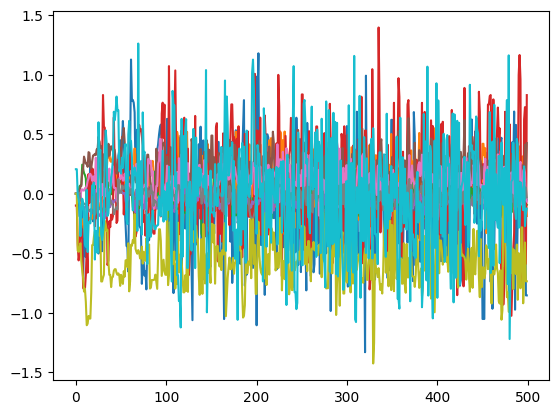

In [125]:
for ii in range(10):
    plt.plot(adapt_info.state.position['dx'][ii, 0, :])

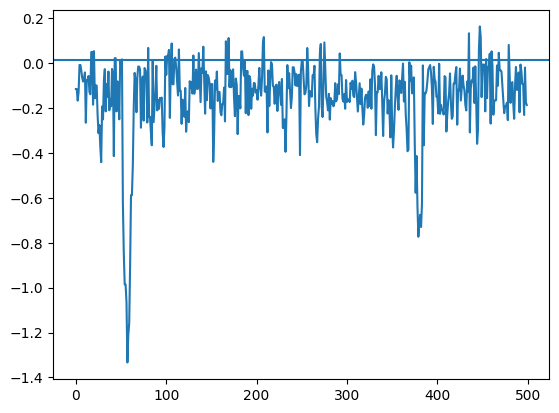

In [119]:
plt.plot(adapt_info.state.position['lhlr'][9, 3, :])
plt.axhline(true_params['lhlr'][9])

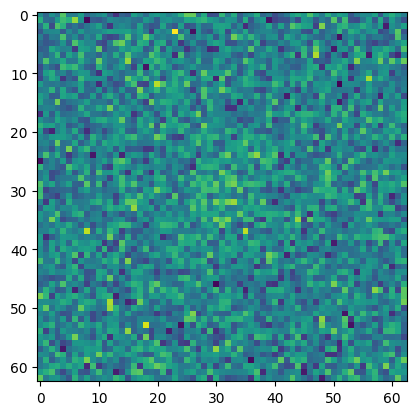

In [124]:
plt.imshow(target_images[9])

In [121]:
10**true_params['lf'][9]

Array(131.603787, dtype=float64)

In [ ]:
        # inference
        t1 = time.time()
        samples, _ = run_sampling(
            skeys, init_states, tuned_params, target_images, fixed_params
        )
        t2 = time.time()
        t_sampling = t2 - t1

        # for logging
        true_params["dx"] = jnp.zeros_like(true_params.pop("x"))
        true_params["dy"] = jnp.zeros_like(true_params.pop("y"))

        results[n_gals] = {}
        results[n_gals]["t_warmup"] = t_warmup
        results[n_gals]["t_sampling"] = t_sampling
        results[n_gals]["samples"] = samples
        results[n_gals]["truth"] = true_params
        results[n_gals]["adapt_info"] = adapt_info
        results[n_gals]["tuned_params"] = tuned_params

    jnp.save(fpath, results)

## Check exp21 samples

In [22]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["JAX_PLATFORMS"] = "cpu"
os.environ["JAX_ENABLE_X64"] = "True"


In [25]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt 
ds = jnp.load("/pscratch/sd/i/imendoza/data/cache_chains/exp21_42/chain_results_42.npy", allow_pickle=True).item()

In [26]:
ds.keys()

dict_keys([1, 5, 10, 25, 50, 100, 250])

In [28]:
ds[250].keys()

dict_keys(['t_warmup', 't_sampling', 'samples', 'truth', 'adapt_info', 'tuned_params'])

In [31]:
ds[250]['adapt_info'].state.position['lf']

Array([[[2.32992299, 2.32992299, 2.32992299, ..., 2.32992299,
         2.32992299, 2.32992299],
        [2.32992299, 2.32992299, 2.32992299, ..., 2.32992299,
         2.32992299, 2.32992299],
        [2.32992299, 2.32992299, 2.32992299, ..., 2.32992299,
         2.32992299, 2.32992299],
        [2.32992299, 2.32992299, 2.32992299, ..., 2.32992299,
         2.32992299, 2.32992299]],

       [[2.34765414, 2.34765414, 2.34765414, ..., 2.34765414,
         2.34765414, 2.34765414],
        [2.34765414, 2.34765414, 2.34765414, ..., 2.34765414,
         2.34765414, 2.34765414],
        [2.34765414, 2.34765414, 2.34765414, ..., 2.34765414,
         2.34765414, 2.34765414],
        [2.34765414, 2.34765414, 2.34765414, ..., 2.34765414,
         2.34765414, 2.34765414]],

       [[2.68799916, 2.68799916, 2.68799916, ..., 2.68799916,
         2.68799916, 2.68799916],
        [2.68799916, 2.68799916, 2.68799916, ..., 2.68799916,
         2.68799916, 2.68799916],
        [2.68799916, 2.68799916, 2.6

In [4]:
ds[250]['samples']['e1'].shape

(250, 4, 500)

In [5]:
ds[10]['truth']['e1'].shape

(10,)

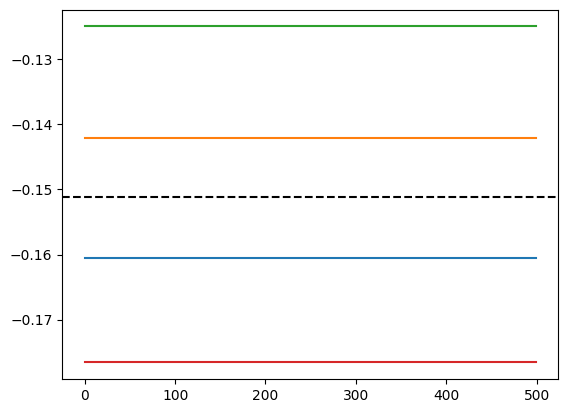

In [11]:
idx = 8
for ii in range(4): 
    plt.plot(ds[10]['samples']['lhlr'][idx, ii])
plt.axhline(ds[10]['truth']['lhlr'][idx], linestyle='--', color='k')


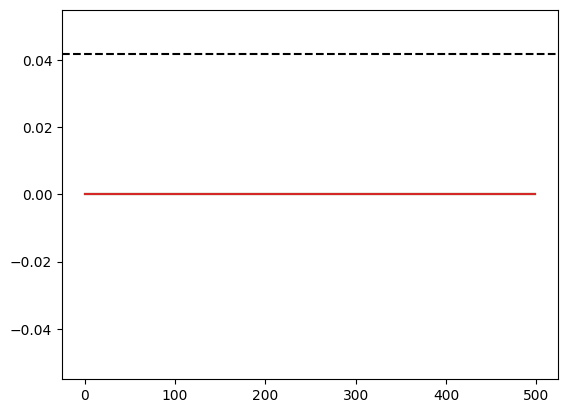

In [13]:
idx = 2
for ii in range(4): 
    plt.plot(ds[10]['samples']['e1'][idx, ii])
plt.axhline(ds[10]['truth']['e1'][idx], linestyle='--', color='k')


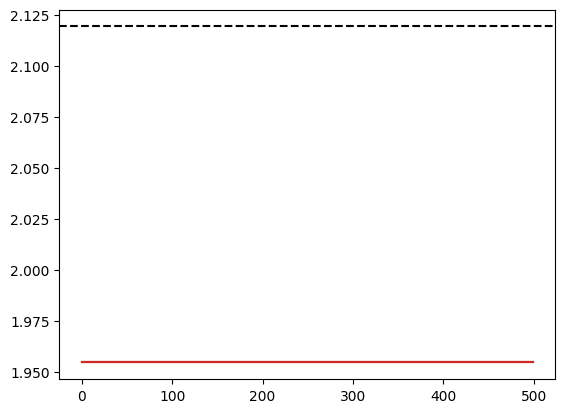

In [20]:
idx = 9
for ii in range(4): 
    plt.plot(ds[10]['samples']['lf'][idx, ii])
plt.axhline(ds[10]['truth']['lf'][idx], linestyle='--', color='k')


In [9]:
ds[10]['truth'].keys()

dict_keys(['e1', 'e2', 'lf', 'lhlr', 'dx', 'dy'])